
Processing Fold1...

[0]	valid-ndcg@32:0.68768
XGBoost Exact (Fold1) - Iter 0: NDCG@10 = 0.4267, Time = 0.09s
[1]	valid-ndcg@32:0.70438
XGBoost Exact (Fold1) - Iter 1: NDCG@10 = 0.4435, Time = 0.16s
[2]	valid-ndcg@32:0.70031
XGBoost Exact (Fold1) - Iter 2: NDCG@10 = 0.4438, Time = 0.23s
[3]	valid-ndcg@32:0.70649
XGBoost Exact (Fold1) - Iter 3: NDCG@10 = 0.4510, Time = 0.30s
[4]	valid-ndcg@32:0.70559
XGBoost Exact (Fold1) - Iter 4: NDCG@10 = 0.4511, Time = 0.37s
[5]	valid-ndcg@32:0.70431
XGBoost Exact (Fold1) - Iter 5: NDCG@10 = 0.4518, Time = 0.43s
[6]	valid-ndcg@32:0.70359
XGBoost Exact (Fold1) - Iter 6: NDCG@10 = 0.4525, Time = 0.50s
[7]	valid-ndcg@32:0.70418
XGBoost Exact (Fold1) - Iter 7: NDCG@10 = 0.4529, Time = 0.56s
[8]	valid-ndcg@32:0.70637
XGBoost Exact (Fold1) - Iter 8: NDCG@10 = 0.4534, Time = 0.63s
[9]	valid-ndcg@32:0.70693
XGBoost Exact (Fold1) - Iter 9: NDCG@10 = 0.4527, Time = 0.69s
[10]	valid-ndcg@32:0.70672
XGBoost Exact (Fold1) - Iter 10: NDCG@10 = 0.4533, Time = 0.7

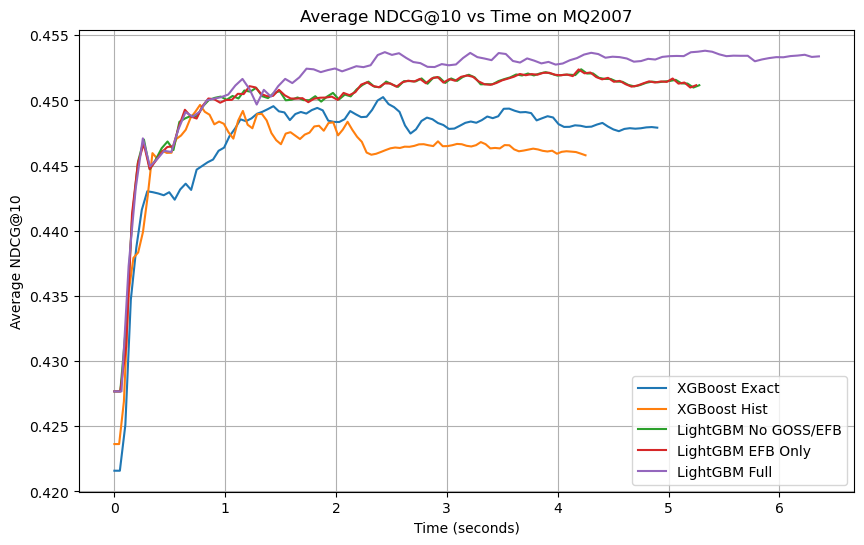

In [2]:
import time
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt

def load_letor_data(file_path):
    X, y, qid = load_svmlight_file(file_path, query_id=True)
    group = np.unique(qid, return_counts=True)[1]
    return X, y, group, qid

# compute NDCG@10
def compute_ndcg(preds, true_labels, qid, group):
    start = 0
    ndcg_scores = []
    for g in group:
        end = start + g
        true = true_labels[start:end]
        pred = preds[start:end]
        if len(true) > 1:  
            ndcg_scores.append(ndcg_score([true], [pred], k=10))
        start = end
    return np.mean(ndcg_scores) if ndcg_scores else 0

# LightGBM callback
def create_lgb_callback(X, y, group, qid, name):
    times = []
    ndcgs = []
    start_time = time.time()

    def callback(env):
        preds = env.model.predict(X)
        ndcg = compute_ndcg(preds, y, qid, group)
        elapsed = time.time() - start_time
        times.append(elapsed)
        ndcgs.append(ndcg)
        print(f"{name} - Iter {env.iteration}: NDCG@10 = {ndcg:.4f}, Time = {elapsed:.2f}s")

    callback.times = times
    callback.ndcgs = ndcgs
    return callback

# XGBoost callback
class XGBTimeNDCGCallback(xgb.callback.TrainingCallback):
    def __init__(self, X, y, group, qid, name):
        self.X = X
        self.y = y
        self.group = group
        self.qid = qid
        self.name = name
        self.times = []
        self.ndcgs = []
        self.start_time = time.time()

    def after_iteration(self, model, epoch, evals_log):
        preds = model.predict(self.X)
        ndcg = compute_ndcg(preds, self.y, self.qid, self.group)
        elapsed = time.time() - self.start_time
        self.times.append(elapsed)
        self.ndcgs.append(ndcg)
        print(f"{self.name} - Iter {epoch}: NDCG@10 = {ndcg:.4f}, Time = {elapsed:.2f}s")
        return False

# augument
num_rounds = 200
early_stopping_rounds = 20
folds = ["Fold1", "Fold2", "Fold3", "Fold4", "Fold5"]

results = {
    "XGBoost Exact": [],
    "XGBoost Hist": [],
    "LightGBM No GOSS/EFB": [],
    "LightGBM EFB Only": [],
    "LightGBM Full": []
}
#------- experiment-----------#
for fold in folds:
    print(f"\nProcessing {fold}...\n")
    
    # load dataset
    train_X, train_y, train_group, train_qid = load_letor_data(f"MQ2007/{fold}/train.txt")
    valid_X, valid_y, valid_group, valid_qid = load_letor_data(f"MQ2007/{fold}/vali.txt")
    test_X, test_y, test_group, test_qid = load_letor_data(f"MQ2007/{fold}/test.txt")

    # create dataset
    dtrain_xgb = xgb.DMatrix(train_X, label=train_y, group=train_group)
    dvalid_xgb = xgb.DMatrix(valid_X, label=valid_y, group=valid_group)
    dtrain_lgb = lgb.Dataset(train_X, label=train_y, group=train_group)
    dvalid_lgb = lgb.Dataset(valid_X, label=valid_y, group=valid_group)

    # experimrnt 1: XGBoost-exa
    params_xgb_exact = {
        'objective': 'rank:pairwise',
        'learning_rate': 0.05,
        'max_depth': 6,
        'tree_method': 'exact'
    }
    callback_xgb_exact = XGBTimeNDCGCallback(dvalid_xgb, valid_y, valid_group, valid_qid, f"XGBoost Exact ({fold})")
    bst_xgb_exact = xgb.train(params_xgb_exact, dtrain_xgb, num_rounds, evals=[(dvalid_xgb, 'valid')],
                              early_stopping_rounds=early_stopping_rounds, callbacks=[callback_xgb_exact])
    results["XGBoost Exact"].append((callback_xgb_exact.times, callback_xgb_exact.ndcgs))

    # experimrnt 2: XGBoost-his
    params_xgb_hist = {
        'objective': 'rank:pairwise',
        'learning_rate': 0.05,
        'max_depth': 6,
        'tree_method': 'hist'
    }
    callback_xgb_hist = XGBTimeNDCGCallback(dvalid_xgb, valid_y, valid_group, valid_qid, f"XGBoost Hist ({fold})")
    bst_xgb_hist = xgb.train(params_xgb_hist, dtrain_xgb, num_rounds, evals=[(dvalid_xgb, 'valid')],
                             early_stopping_rounds=early_stopping_rounds, callbacks=[callback_xgb_hist])
    results["XGBoost Hist"].append((callback_xgb_hist.times, callback_xgb_hist.ndcgs))

    # LightGBM augument
    base_params_lgb = {
        'objective': 'lambdarank',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'metric': 'ndcg',
        'ndcg_eval_at': [10],
        'verbose': -1
    }

    # experimrnt 3: LightGBM-baseline
    dataset_params_no_goss_efb = {'enable_bundle': False}  
    dtrain_lgb_no_goss_efb = lgb.Dataset(train_X, label=train_y, group=train_group, params=dataset_params_no_goss_efb)
    dvalid_lgb_no_goss_efb = lgb.Dataset(valid_X, label=valid_y, group=valid_group, params=dataset_params_no_goss_efb)
    params_lgb_no_goss_efb = base_params_lgb.copy()
    params_lgb_no_goss_efb.update({'boosting': 'gbdt'}) 
    callback_lgb_no_goss_efb = create_lgb_callback(valid_X, valid_y, valid_group, valid_qid, "LightGBM No GOSS/EFB")
    bst_lgb_no_goss_efb = lgb.train(params_lgb_no_goss_efb, dtrain_lgb_no_goss_efb, num_rounds, 
                                    valid_sets=[dvalid_lgb_no_goss_efb],
                                    callbacks=[lgb.early_stopping(early_stopping_rounds), callback_lgb_no_goss_efb])
    results["LightGBM No GOSS/EFB"].append((callback_lgb_no_goss_efb.times, callback_lgb_no_goss_efb.ndcgs))

    # experimrnt 4: LightGBM-EFB only
    dataset_params_efb = {'enable_bundle': True}  
    dtrain_lgb_efb = lgb.Dataset(train_X, label=train_y, group=train_group, params=dataset_params_efb)
    dvalid_lgb_efb = lgb.Dataset(valid_X, label=valid_y, group=valid_group, params=dataset_params_efb)
    params_lgb_efb = base_params_lgb.copy()
    params_lgb_efb.update({'boosting': 'gbdt'})  
    callback_lgb_efb = create_lgb_callback(valid_X, valid_y, valid_group, valid_qid, "LightGBM EFB Only")
    bst_lgb_efb = lgb.train(params_lgb_efb, dtrain_lgb_efb, num_rounds, valid_sets=[dvalid_lgb_efb],
                            callbacks=[lgb.early_stopping(early_stopping_rounds), callback_lgb_efb])
    results["LightGBM EFB Only"].append((callback_lgb_efb.times, callback_lgb_efb.ndcgs))

    # experimrnt 5: LightGBM-full
    dataset_params_full = {'enable_bundle': True}  
    dtrain_lgb_full = lgb.Dataset(train_X, label=train_y, group=train_group, params=dataset_params_full)
    dvalid_lgb_full = lgb.Dataset(valid_X, label=valid_y, group=valid_group, params=dataset_params_full)
    params_lgb_full = base_params_lgb.copy()
    params_lgb_full.update({'boosting': 'goss'})  
    callback_lgb_full = create_lgb_callback(valid_X, valid_y, valid_group, valid_qid, "LightGBM Full")
    bst_lgb_full = lgb.train(params_lgb_full, dtrain_lgb_full, num_rounds, valid_sets=[dvalid_lgb_full],
                             callbacks=[lgb.early_stopping(early_stopping_rounds), callback_lgb_full])
    results["LightGBM Full"].append((callback_lgb_full.times, callback_lgb_full.ndcgs))

print("\nAverage Training Time Across 5 Folds (seconds):")
avg_times = {}
for method in results:
    total_time = 0
    for times, _ in results[method]:
        total_time += max(times)  
    avg_time = total_time / len(folds)
    avg_times[method] = avg_time
    print(f"{method}: {avg_time:.2f} seconds")

# compute average NDCG
def interpolate_and_average(times_list, ndcgs_list, max_time):
    avg_times = np.linspace(0, max_time, 100)  
    avg_ndcgs = []
    for times, ndcgs in zip(times_list, ndcgs_list):
        interp_ndcg = np.interp(avg_times, times, ndcgs)
        avg_ndcgs.append(interp_ndcg)
    return avg_times, np.mean(avg_ndcgs, axis=0)

# compute average time
max_times = {}
for method in results:
    times_list, ndcgs_list = zip(*results[method])
    max_times[method] = max(max(times) for times in times_list)

# plot
plt.figure(figsize=(10, 6))
for method in results:
    times_list, ndcgs_list = zip(*results[method])
    avg_times, avg_ndcgs = interpolate_and_average(times_list, ndcgs_list, max_times[method])
    plt.plot(avg_times, avg_ndcgs, label=method)

plt.xlabel("Time (seconds)")
plt.ylabel("Average NDCG@10")
plt.title("Average NDCG@10 vs Time on MQ2007")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
for method in results:
    times_list, ndcgs_list = zip(*results[method])
    avg_times, avg_ndcgs = interpolate_and_average(times_list, ndcgs_list, max_times[method])
    print(f"{method}: {avg_ndcgs[-1]:.4f}")

XGBoost Exact: 0.4479
XGBoost Hist: 0.4458
LightGBM No GOSS/EFB: 0.4512
LightGBM EFB Only: 0.4512
LightGBM Full: 0.4534
